# First order ZV-MCMC estimates

Ce notebook répond à **deuxième question** du projet.

Avec la méthode Ordinary-MCMC, nous avons déterminé l'estimateur en approximant l'espérance du vecteur de paramètres cible $ \boldsymbol{\omega} = (\omega_1, \omega_2, \omega_3) $ en fonction des données par une moyenne empirique sur 2000 itérations.

La méthode Zero-Variance Markov Chain Monte Carlo (ZV-MCMC) consiste à réduire l'erreur MCMC en remplaçant directement $ \boldsymbol{\omega} $ par un vecteur $ \tilde{\boldsymbol{\omega}} $ obtenu en rénormalisant correctement $ \boldsymbol{\omega} $. En suivant les directives de l'article, nous introduisons un polynôme de premier degré pour construire $ \tilde{\boldsymbol{\omega}} $, de telle sorte que son espérance soit égale à $ \mathbb{E}[\boldsymbol{\omega}] $, mais sa variance soit beaucoup plus petite.

**Procédure ZV-MCMC :**

- *Première étape* : Utilisation d'une courte simulation MCMC (2000 itérations) pour estimer les coefficients des variables de contrôle.

- *Deuxième étape* : Utilisation d'une longue simulation MCMC (10000 itérations) pour estimer la moyenne postérieure de chaque paramètre sous la forme rénormalisée en introduisant les variables de contrôle.


## Importation des librairies  

In [ ]:
! pip install import-ipynb
! pip install ipynb
! pip install arch
! pip install numpy 
! pip install matplotlib
! pip install scikit-learn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from arch.univariate import GARCH, ZeroMean
import pandas as pd 
from math import log 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import statsmodels.api as sm
import pickle

## Expressions des variables de contrôle de premier ordre

Dans cette partie, nous présentons deux approches pour calculer les expressions des variables de contrôle de premier ordre utilisées dans la méthode ZV-MCMC.   

L'expression d'une variable de contrôle $ z_i $ avec $ i $ appartenant à $ {1, 2, 3\} est donnée par :
$$
$ z_i $ = \frac{\partial \ln \pi}{\partial \omega_i} = \frac{\omega_i}{2\sigma^2(\omega_i)} + \frac{1}{4} \sum_{t=1}^{T} \frac{1}{h_t} \frac{\partial h_t}{\partial \omega_i} - \frac{1}{4} \sum_{t=1}^{T} \frac{r_t^2}{h_t^2} \frac{\partial h_t}{\partial \omega_i}, \quad i = 1, 2, 3,
$$


### Première approche

In [57]:
def z1(x,r,var):
    Z = 0
    h = 0 

    for i in range(1, len(r)):
        h = x[0] + x[1] * r[i-1]**2 + x[2] * h
        Z += (1-x[2]**(i))/(1-x[2]) * (-(0.5/h) + (0.5 * r[i]**2)/(h**2))
    return -1/2 * (- x[0]/var[0] + Z)

def z2(x , r,var):
    Z = 0
    h_t = 0
    dht_domega2 = 0 #initial derivatves of h wrt alpha (x[1])
    
    for i in range(1, len(r)):
        h = h_t
        dht_domega2 = r[i-1]**2 + x[2]*dht_domega2
        h_t = x[0] + x[1] * r[i-1]**2 + x[2] * h
        Z += (dht_domega2) * (-(0.5/h_t) + (0.5 * r[i]**2)/(h_t**2))
    return -1/2 * (- x[1]/var[1] + Z)


def z3(x , r, var):
    Z = 0
    h_t = 0
    dht_domega3 = 0 #initial derivatves of h wrt beta (x[2])
    for i in range(1, len(r)):
        h = h_t
        dht_domega3 = h + x[2]*dht_domega3
        h_t = x[0] + x[1] * r[i-1]**2 + x[2] * h
        Z += (dht_domega3) * (-(0.5/h_t) + (0.5 * r[i]**2)/(h_t**2))
    return -1/2 * (- x[2]/var[2] + Z)

In [58]:
def calcul_z_1(echant, r, var):
    """
    Cette fonction calcule le vecteur des variables de contrôle suivant la première méthode,
    en faisont appel aux fonctions z1(), z2() et z3().

    Args:
        echant (array): échantillon du vecteur des paramètres omega_1, omega_2 et omega_3.
        h (list) : échantillon des données de volatilité (h_t).
        r (list) : données des rendements logarithmques (r_t).
        var_emp (array): Liste des variances empiriques estimées pour omega_1, omega_2 et omega_3.

    Returns:
        array: une matrice où les variables z_1, z_2, et z_3 sont empilées en colonnes.
    """
    Z1 = []
    Z2 = []
    Z3 = []

    for x in echant:
        Z1.append(z1(x, r, var))
        Z2.append(z2(x, r, var))
        Z3.append(z3(x, r, var))
    return np.column_stack([Z1, Z2, Z3])

Dans la **deuxième approche**, nous présentons une fonction qui calcule les $ z_i $ à partir de leur expression théorique, dont le calcul est détaillé dans les diapositives. Les expressions finales sont :

$$
z_1 = \frac{\omega_1}{2\sigma^2(\omega_1)} + \frac{1}{4} \sum_{t=1}^{T} \frac{1}{h_t} \left(\frac{ 1 - \omega_{3}^{t-1}}{1 - \omega_3} \right) - \frac{1}{4} \sum_{t=1}^{T} \frac{r_t^2}{h_t^2} \left(\frac{ 1 - \omega_{3}^{t-1}}{1 - \omega_3}\right)
$$

$$
z_2 = \frac{\omega_2}{2\sigma^2(\omega_2)} + \frac{1}{4} \sum_{t=2}^{T} \frac{1}{h_t} \left(\sum_{i=1}^{t-1} \omega_3^{t-1-i} \cdot r_i^2 \right) - \frac{1}{4} \sum_{t=2}^{T} \frac{r_t^2}{h_t^2} \left(\sum_{i=1}^{t-1} \omega_3^{t-1-i} \cdot r_i^2 \right)
$$

$$
z_3 = \frac{\omega_3}{2\sigma^2(\omega_3)} + \frac{1}{4} \sum_{t=2}^{T} \frac{1}{h_t} \left(\sum_{i=1}^{t-1} \omega_3^{t-1-i} \cdot r_i^2\right) - \frac{1}{4} \sum_{t=2}^{T} \frac{r_t^2}{h_t^2} \left(\sum_{i=1}^{t-1} \omega_3^{t-1-i} \cdot h_i^2 \right)
$$

Ces expressions sont utilisées pour calculer les $ z_i $ dans la méthode ZV-MCMC. Elles sont obtenues en utilisant les expressions théoriques détaillées dans les diapositives.


### Deuxième méthode

In [3]:
def calcul_z_2(omega_1, omega_2, omega_3, h, r, var_emp):
    """
    Cette fonction calcule le vecteur des variables de contrôle suivant la première méthode.

    Args:
        omega_1 (array): échantillon du vecteur omega_1.
        omega_2 (array): échantillon du vecteur omega_2.
        omega_3 (array): échantillon du vecteur omega_3.
        h (list) : échantillon des données de volatilité (h_t).
        r (list) : données des rendements logarithmques (r_t).
        var_emp (array): Liste des variances empiriques estimées pour omega_1, omega_2 et omega_3.

    Returns:
        array: une matrice où les variables z_1, z_2, et z_3 sont empilées en colonnes.
    """
    T = len(h)
    z_1 = omega_1 / (2 * var_emp[0] ** 2)
    z_2 = omega_2 / (2 * var_emp[1] ** 2)
    z_3 = omega_3 / (2 * var_emp[2] ** 2)
    
    for t in range(1,T):
        dht_domega1 = (1 - omega_3 ** (t-1)) / (1 - omega_3)
        z_1 += 0.25 * (1/h[t]) * dht_domega1 - int((r[t] ** 2 / h[t]**2)) * dht_domega1
        dht_domega2 = np.array([np.sum([w_i**(t-2-i) * r[i]**2 for i in range(t-1)]) for w_i in omega_2])
        z_2 += 0.25 * (1/h[t]) * dht_domega2 - r[t] ** 2 / h[t]**2 * dht_domega2
        dht_domega3 = np.array([np.sum([w_i**(t-2-i) * h[i]**2 for i in range(t-1)]) for w_i in omega_3])
        z_3 += 0.25 * (1/h[t]) * dht_domega3 - (r[t] ** 2 / h[t]) * dht_domega3
    return np.column_stack([z_1, z_2, z_3])

In [152]:
# Chargement des variables
with open('donnees4.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

y = loaded_data['y']
r = loaded_data['r']
h = loaded_data['h']
echant_sim = loaded_data['echant_sim']
echant_reel = loaded_data['echant_reel']
echant_sim_10000 = loaded_data['echant_sim_10000']
echant_reel_10000 = loaded_data['echant_reel_10000']

Dans ce qui suit, nous calculons les variables contrôle suivant les deux approches et en utilisant les échantillons de paramètres obtenus à partir de la courte simulation MCMC (3000 itérations).

In [153]:
# Calcul des variables de contrôle suivant l'approche 1
## pour les données simulées
CV1_sim_1 = calcul_z_1(echant_sim, y[:100], [100,100,100])
## pour les données réelles
omega1 = echant_reel[:,0].mean()
omega2 = echant_reel[:,1].mean()
omega3 = echant_reel[:,2].mean()
h_reel = np.zeros(len(r[:100])) 
# On estime la variance conditionnelle des données réelles en estimant les omegas par les moyennes empiriques de l'échantillon généré
for t in range(1,len(r[:100])) :
    h_reel[t] = omega1 + omega2 * h_reel[t-1] + omega3 * r[t-1]**2
CV1_reel_1 = calcul_z_1(echant_reel, r[:100], [100,100,100])

In [154]:
# Calcul des variables de contrôle suivant l'approche 2
## pour les données simulées
CV1_sim_2 = calcul_z_2(echant_sim[:,0], echant_sim[:,1], echant_sim[:,2], h[:100], y[:100], [100,100,100])
## pour les données réelles
omega1 = echant_reel[:,0].mean()
omega2 = echant_reel[:,1].mean()
omega3 = echant_reel[:,2].mean()
h_reel = np.zeros(len(r[:100])) 
# On estime la variance conditionnelle des données réelles en estimant les omegas par les moyennes empiriques de l'échantillon généré
for t in range(1,len(r[:100])) :
    h_reel[t] = omega1 + omega2 * h_reel[t-1] + omega3 * r[t-1]**2
CV1_reel_2 = calcul_z_2(echant_reel[:,0], echant_reel[:,1], echant_reel[:,2], h_reel, r[:100], [100,100,100])

Un critère primordial pour le choix des variables de contrôle est que leur espérance soit nulle. Ainsi, pour trancher entre deux approches de calcul, nous choisissons celle qui donne lieu aux variables avec les espérances les plus petites possibles, plus proches de zéro si possible. 

In [96]:
def calculate_means(x):
    return [x[:,0].mean(), x[:,1].mean(), x[:,2].mean()]

In [143]:
print("Moyennes des variables de de contrôle suivant l'approche 1 (échantillon à partir des données simulées) :", calculate_means(CV1_sim_1))
print("Moyennes des variables de de contrôle suivant l'approche 1 (échantillon à partir des données réelles) :", calculate_means(CV1_reel_1))
print("Moyennes des variables de de contrôle suivant l'approche 2 (échantillon à partir des données simulées) :", calculate_means(CV1_reel_2))
print("Moyennes des variables de de contrôle suivant l'approche 2 (échantillon à partir des données réelles) :", calculate_means(CV1_sim_2))

Moyennes des variables de de contrôle suivant l'approche 1 (échantillon à partir des données simulées) : [-0.8635705504322886, -0.01776304324595477, 3.2582308283462673]
Moyennes des variables de de contrôle suivant l'approche 1 (échantillon à partir des données réelles) : [-2.4533548218703514, -0.7642729024573065, -1.026694469506562]
Moyennes des variables de de contrôle suivant l'approche 2 (échantillon à partir des données simulées) : [2.2401138690392393, -102.03739080647199, -4179.738324658718]
Moyennes des variables de de contrôle suivant l'approche 2 (échantillon à partir des données réelles) : [-0.3903764646015252, -7.557028963810246e+22, -7433.278588670329]


La première approche donne de meilleurs résultats par rapport à la deuxième approche.

Dans ce qui suit, nous adoptons la première approche et donc la fonction *calcul_z_2* pour générer les variables de contrôle.

On génère un nouveau échantillon de variables de contrôle en utilisant la première approche et une longue simulation MCMC (10000 itérations) pour estimer la moyenne postérieure de chaque paramètre sous la forme rénormalisée en introduisant les variables de contrôle.

In [162]:

CV1_nv_sim_2= calcul_z_2(echant_sim_10000[:,0], echant_sim_10000[:,1], echant_sim_10000[:,2], h[:100], y[:100], [100,100,100])
CV1_nv_reel_2= calcul_z_2(echant_reel_10000[:,0], echant_reel_10000[:,1], echant_reel_10000[:,2], h_reel, r[:100], [100,100,100])


In [130]:
def centrer_matrice(matrice):
    moyennes = np.mean(matrice, axis=0)
    matrice_centree = matrice - moyennes
    return matrice_centree


In [132]:
CV1_nv_sim_2_centred = centrer_matrice(CV1_nv_sim_2)
CV1_sim_2_centred = centrer_matrice(CV1_sim_2)

In [114]:
def enlever_outliers2(data):
    Q1 = np.percentile(data, 10)
    Q3 = np.percentile(data, 90)
    IQR = Q3 - Q1

    # Définition des limites
    limite_inferieure = Q1 - 3 * IQR
    limite_superieure = Q3 + 3 * IQR
    
    # Filtrage des outliers
    data_filtree = np.copy(data)
    for i in range(1, len(data)):
        if (data[i] < limite_inferieure) or (data[i] > limite_superieure):
            data_filtree[i] = data_filtree[i - 1]
    
    return data_filtree

In [163]:
def combi_omega(k, echant_sim, CV1_sim, CV1_nv_sim):

    model = sm.OLS(echant_sim[:,k], CV1_sim) # CV1_sim = sm.add_constant(CV1_sim)
    results = model.fit(cov_type='HC3')
    coeff_opt = results.params # CV1_nv_sim1 = np.insert(CV1_nv_sim, 0, 1, axis=1)
    combi = np.dot(coeff_opt, CV1_nv_sim.transpose())
    print(results.summary())
    return combi


# ------------------------------------- Omega_1----------------------------------------------------------------

combi_omega1 = combi_omega(0, echant_sim, CV1_sim_2, CV1_nv_sim_2)
omega_tilde_1 = echant_sim_10000[:,0] - combi_omega1
omega_tilde_1ss = enlever_outliers2(omega_tilde_1)

# ------------------------------------- Omega_2----------------------------------------------------------------

combi_omega2 = combi_omega(1, echant_sim, CV1_sim_2, CV1_nv_sim_2)
omega_tilde_2 = echant_sim_10000[:,1] - combi_omega2
omega_tilde_2ss = enlever_outliers2(omega_tilde_2)

# ------------------------------------- Omega_3----------------------------------------------------------------

combi_omega3 = combi_omega(2, echant_sim, CV1_sim_2, CV1_nv_sim_2)
omega_tilde_3 = echant_sim_10000[:,2] - combi_omega3
omega_tilde_3ss = enlever_outliers2(omega_tilde_3)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                      -0.050
Model:                            OLS   Adj. R-squared:                 -0.050
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 29 Apr 2024   Prob (F-statistic):                nan
Time:                        20:07:56   Log-Likelihood:                 7972.4
No. Observations:                3001   AIC:                        -1.594e+04
Df Residuals:                    2998   BIC:                        -1.592e+04
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -7.237e-05   2.97e-06    -24.348      0.0

In [123]:
# Les variables de contrôle pour les données réelles

# ------------------------------------- Omega_1----------------------------------------------------------------

combi_omega1_reel = combi_omega(0, echant_reel, CV1_reel_2, CV1_nv_reel_2)
omega_tilde_1_reel = echant_reel_10000[:,1] - combi_omega1_reel
#omega_tilde_1ss_reel = enlever_outliers(omega_tilde_1_reel)

# ------------------------------------- Omega_2----------------------------------------------------------------
combi_omega2_reel = combi_omega(1, echant_reel, CV1_reel_2, CV1_nv_reel_2)
omega_tilde_2_reel = echant_reel_10000[:,1] - combi_omega2_reel
#omega_tilde_2ss_reel = enlever_outliers(omega_tilde_2_reel)

# ------------------------------------- Omega_3----------------------------------------------------------------
combi_omega3_reel = combi_omega(2, echant_reel, CV1_reel_2, CV1_nv_reel_2)
omega_tilde_3_reel = echant_reel_10000[:,1] - combi_omega3_reel
#omega_tilde_3ss_reel = enlever_outliers(omega_tilde_3_reel)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.954
Model:                            OLS   Adj. R-squared (uncentered):              0.954
Method:                 Least Squares   F-statistic:                          1.999e+04
Date:                Mon, 29 Apr 2024   Prob (F-statistic):                        0.00
Time:                        19:08:00   Log-Likelihood:                          7665.2
No. Observations:                3001   AIC:                                 -1.532e+04
Df Residuals:                    2998   BIC:                                 -1.531e+04
Df Model:                           3                                                  
Covariance Type:                  HC3                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

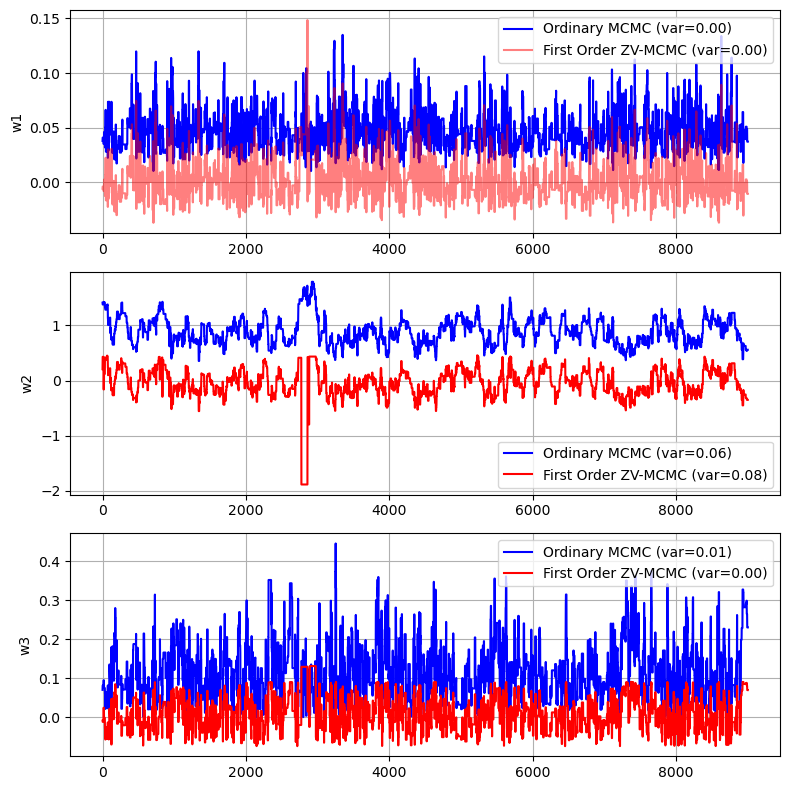

In [164]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

# Première figure
variance_1 = echant_sim_10000[:,0][1000:].var()
variance_2 = omega_tilde_1ss[1000:].var()
axs[0].plot(range(9001), echant_sim_10000[:,0][1000:], color='blue', label='Ordinary MCMC (var=%.2f)' % variance_1)
axs[0].plot(range(9001), omega_tilde_1ss[1000:], color='red', label='First Order ZV-MCMC (var=%.2f)' % variance_2, alpha = 0.5)
axs[0].set_ylabel('w1')
axs[0].legend()
axs[0].grid()

# Deuxième figure
variance_1 = echant_sim_10000[:,1][1000:].var()
variance_2 = omega_tilde_2ss[1000:].var()
axs[1].plot(range(9001), echant_sim_10000[:,1][1000:], color='blue', label='Ordinary MCMC (var=%.2f)' % variance_1)
axs[1].plot(range(9001), omega_tilde_2ss[1000:], color='red', label='First Order ZV-MCMC (var=%.2f)' % variance_2)
axs[1].set_ylabel('w2')
axs[1].legend()
axs[1].grid()

# Troisième figure
variance_1 = echant_sim_10000[:,2][1000:].var()
variance_2 = omega_tilde_3ss[1000:].var()
axs[2].plot(range(9001), echant_sim_10000[:,2][1000:], color='blue', label='Ordinary MCMC (var=%.2f)' % variance_1)
axs[2].plot(range(9001), omega_tilde_3ss[1000:], color='red', label='First Order ZV-MCMC (var=%.2f)' % variance_2)
axs[2].set_ylabel('w3')
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()


In [146]:
print(omega_tilde_1ss.mean(), omega_tilde_2ss.mean(), omega_tilde_3ss.mean())

0.9762192399048485 0.8822673986813261 0.12416766600555323


In [147]:
print(echant_sim_10000[:,0].mean(), echant_sim_10000[:,1].mean(), echant_sim_10000[:,2].mean())

0.9762192399048497 0.8822673986813289 0.12424639069888814


In [79]:
# on enlève ?
def enlever_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)

    IQR = Q3 - Q1

    # Définition des limites
    limite_inferieure = Q1 - 10 * IQR
    limite_superieure = Q3 + 10 * IQR
    donnees_sans_outliers = np.copy(data)
    for i in range(1, len(data)):
        if (data[i] < limite_inferieure).any() or (data[i] > limite_superieure).any():
            donnees_sans_outliers[i] = donnees_sans_outliers[i - 1]
    return donnees_sans_outliers

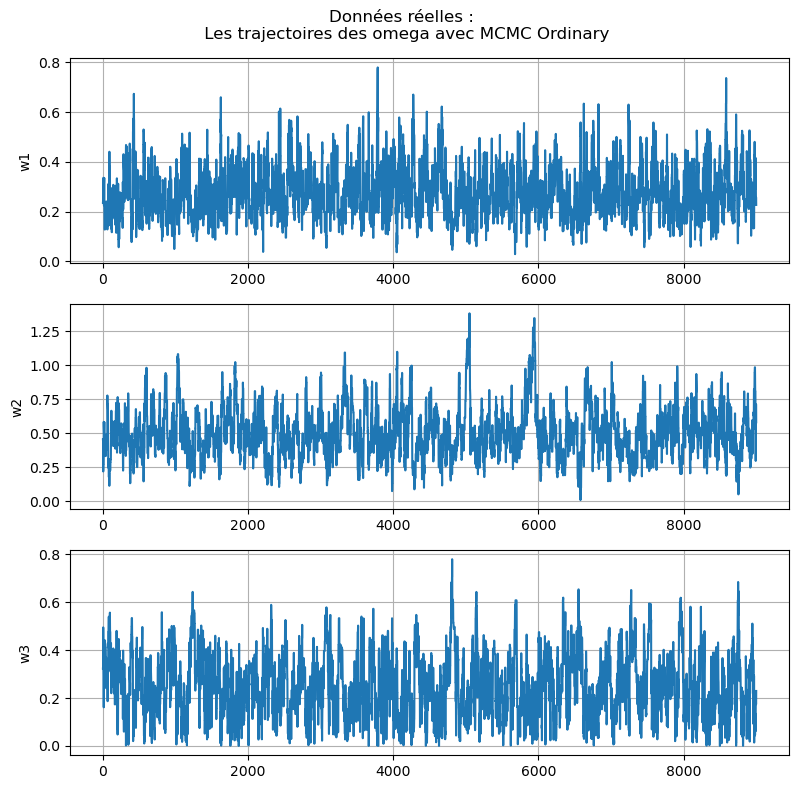

In [108]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
axs[0].plot(range(9001), echant_sim_10000[1000:, 0])
axs[0].set_ylabel('w1')
axs[0].grid()

axs[1].plot(range(9001), echant_sim_10000[1000:, 1])
axs[1].set_ylabel('w2')
axs[1].grid()

axs[2].plot(range(9001), echant_sim_10000[1000:, 2])
axs[2].set_ylabel('w3')
axs[2].grid()

plt.suptitle("Données réelles : \n Les trajectoires des omega avec MCMC Ordinary")
plt.tight_layout()
plt.show()

